In [1]:
# Imports
import torch
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # To inherit our neural network
import matplotlib.pyplot as plt
from tqdm import tqdm  # For nice progress bar!
import cv2  # For image transformations
import numpy as np
from random import sample

# For flappy bird
import flappy_fii
import gymnasium

In [2]:
# Define NN

# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class NN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(NN, self).__init__()

        def init_weights(m):
            if isinstance(m, nn.Linear):
                # nn.init.xavier_uniform_(m.weight)
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                m.bias.data.fill_(0.01)

        self.__net = nn.Sequential(
            # First Convolution Layer
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=32,
                kernel_size=(8, 8),
                stride=4,
                padding=0,
            ),
            nn.ReLU(),
            # Second Convolution Layer
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=(4, 4), stride=2, padding=0
            ),
            nn.ReLU(),
            # Third Convolution Layer
            nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=(3, 3), stride=1, padding=0
            ),
            nn.ReLU(),
            # Flatten for Fully Connected Layers
            nn.Flatten(),
            # First Fully Connected Layer
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            # Output Layer
            nn.Linear(512, num_classes),
        )

        self.__net.apply(init_weights)

    def forward(self, x):
        return self.__net(x)

    def predict(self, x):
        self.eval()

        with torch.no_grad():
            # Move data to device
            x = x.to(device=device)

            # Forward
            prediction = self.forward(x)

        self.train()
        return prediction

In [3]:
# Agent
class Agent:
    def __init__(
        self,
        *,
        state_size,
        action_space,
        discount_rate=0.9,
        initial_epsilon=0.1,
        final_epsilon=0.0001,
        decay_length=1_000_000,
        replay_buffer_size=50_000,
        learning_rate=0.000001,
        decay=0.9,
        momentum=0.95,
    ):
        # Hyperparameters
        self.__action_space = action_space
        self.__discount_rate = discount_rate
        self.__initial_epsilon, self.__final_epsilon = initial_epsilon, final_epsilon
        self.__decay_length, self.__epsilon = decay_length, self.__initial_epsilon
        self.__queue_size, self.__width, self.__height = state_size

        # Observe mode flag
        # When true, the Agent will play randomly to fill it's replay buffer, its value is controlled by the user
        self.observe_mode = True

        # Initialize network
        self.__model = NN(
            input_channels=self.__queue_size, num_classes=action_space
        ).to(device)

        # Loss and optimizer
        self.__criterion = nn.MSELoss()
        self.__optimizer = optim.RMSprop(
            self.__model.parameters(), lr=learning_rate, alpha=decay, momentum=momentum
        )

        # Cache latest `queue_size` frames
        self.__queue = torch.tensor([])

        # Replay buffer
        self.__replay_buffer_size = replay_buffer_size
        self.__replay_buffer = []

    def __replay_buffer_append(self, data):
        if len(self.__replay_buffer) == self.__replay_buffer_size:
            self.__replay_buffer.pop(0)

        self.__replay_buffer.append(data)

    def __decay_epsilon(self):
        self.__epsilon = max(
            self.__final_epsilon,
            self.__epsilon
            - (self.__initial_epsilon - self.__final_epsilon) / self.__decay_length,
        )

    def migrate(self, initial_epsilon, final_epsilon, decay_length):
        self.__epsilon = initial_epsilon
        self.__initial_epsilon = initial_epsilon
        self.__final_epsilon = final_epsilon
        self.__decay_length = decay_length

    def preprocess_state(self, state, initial=False):
        # crop bottom of image (i.e. remove the ground)
        state = state[:406]
        # resize image to (width, height)
        state = cv2.resize(
            state, (self.__width, self.__height), interpolation=cv2.INTER_AREA
        )
        # convert to grayscale
        state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)
        # normalize and put state in wanted shape
        state = torch.tensor(state[None, :, :].astype(np.float32) / 255)

        if initial:
            # make sure the queue is filled at the beginning
            self.__queue = torch.cat(
                tuple(state for _ in range(self.__queue_size)), dim=0
            )
        else:
            # pop oldest frame and add newest one
            self.__queue = torch.cat((self.__queue[1:], state), dim=0)

        return self.__queue.unsqueeze(0)

    def next_action(self, state, testing=False):
        """Return next action to perform, given the current state."""
        # if in observe mode, play randomly to fill the replay buffer
        if self.observe_mode or not testing and torch.rand(1).item() < self.__epsilon:
            return torch.randint(low=0, high=self.__action_space, size=(1,)).item()

        # get q values for current state
        q_values = self.__model.predict(state)

        return torch.argmax(q_values).item()

    def train(self, state, action, reward, next_state, done, *, batch_size=32):
        """Update the model using the observed results."""
        # Add current state to replay buffer
        self.__replay_buffer_append((state, action, reward, next_state, done))

        # if in observe mode, no training should be done, just observation
        if self.observe_mode:
            return

        # Compose batch
        batch = sample(self.__replay_buffer, min(len(self.__replay_buffer), batch_size))
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(
            *batch
        )

        # Compute tensors for state, reward and next_state
        state_batch = torch.cat(tuple(s for s in state_batch), dim=0).to(device=device)
        action_batch = torch.tensor(action_batch).to(device=device)
        reward_batch = torch.tensor(reward_batch, dtype=torch.float32).to(device=device)
        next_state_batch = torch.cat(tuple(s for s in next_state_batch), dim=0).to(
            device=device
        )
        done_batch = torch.tensor(done_batch).to(device=device)

        # Forward
        q_values_batch = self.__model.forward(state_batch)
        next_q_values_batch = self.__model.forward(next_state_batch)

        # Compose target values
        q_values_batch = q_values_batch[torch.arange(len(action_batch)), action_batch]
        target_values_batch = torch.tensor(
            [
                (
                    reward
                    if done
                    else reward + self.__discount_rate * torch.max(next_q_values)
                )
                for reward, next_q_values, done in zip(
                    reward_batch,
                    next_q_values_batch,
                    done_batch,
                )
            ]
        ).to(device=device)

        loss = self.__criterion(q_values_batch, target_values_batch)

        # Backward
        self.__optimizer.zero_grad()
        loss.backward()

        # Adam step
        self.__optimizer.step()

        # Decay epsilon after each training call
        self.__decay_epsilon()

    def save(self, to_file="model"):
        # torch.save(self.__model.state_dict(), "model.pt")
        torch.save(obj=self, f=f"states/{to_file}.pt")

    def load(from_file="model") -> "Agent":
        return torch.load(f"states/{from_file}.pt", weights_only=False)

    def test(self):
        """
        Test the agent by printing its key attributes and configuration.
        """
        print("=== Hyperparameters ===")
        print(f"Action Space: {self.__action_space}")
        print(f"Discount Rate: {self.__discount_rate}")
        try:
            print(f"Initial Epsilon: {self.__initial_epsilon}")
            print(f"Final Epsilon: {self.__final_epsilon}")
            print(f"Decay Length: {self.__decay_length}")
        except:
            pass
        print(f"Epsilon: {self.__epsilon}")
        print(
            f"Queue Size: {self.__queue_size}, Width: {self.__width}, Height: {self.__height}"
        )

        print("\n=== Observation Mode ===")
        print(f"Observe Mode: {'Enabled' if self.observe_mode else 'Disabled'}")

        print("\n=== Network Configuration ===")
        print(f"Model: {self.__model}")

        print("\n=== Training Configuration ===")
        print(f"Criterion: {self.__criterion}")
        print(f"Optimizer: {self.__optimizer}")

        print("\n=== Replay Buffer ===")
        print(f"Queue Length: {len(self.__queue)}")
        print(f"Replay Buffer Size: {self.__replay_buffer_size}")
        print(f"Replay Buffer Length: {len(self.__replay_buffer)}")

In [4]:
# Utilities for training/testing


def get_env(
    difficulty: str = "medium",
    from_file: str = None,
    agent_cached: bool = False,
    testing: bool = False,
    testing_render_mode: str = "rgb_array",
):
    # create env
    env = gymnasium.make(
        "FlappyBird-fii-v0",
        render_mode="rgb_array" if not testing else testing_render_mode,
        use_lidar=False,
        background=None,
        rewards={
            "passed_pipe": None,
            "staying_alive": 1.0,
            "outside_screen": -1.0,
            "dying": -1.0,
        },
        pipe_gap=(
            240 if difficulty == "easy" else (170 if difficulty == "medium" else 100)
        ),
        render_fps=30 if not testing else 144,
    )

    # create agent
    if agent_cached:
        agent = None  # don't create a new agent if it's already cached
    elif from_file is not None:
        agent = Agent.load(from_file)
    else:
        agent = Agent(
            state_size=(5, 84, 84),
            action_space=env.action_space.n,
            initial_epsilon=0.1,
            final_epsilon=0.0001,
            decay_length=1_000_000,
            discount_rate=0.95,
        )

    # load scores only if file is specified and not in testing mode
    # to avoid cluttering the memory
    if from_file is not None and not testing:
        scores = torch.load(f"graphs/{from_file}.pt", weights_only=False)
    else:
        scores = []

    return env, agent, scores


def run_agent(
    env: gymnasium.Env,
    agent: Agent,
    scores: list[int],
    epochs: int,
    testing: bool = False,
):
    # Run `epochs` games
    try:
        for _ in tqdm(range(epochs)):
            env.reset()
            state = agent.preprocess_state(env.render(), initial=True)
            done = False  # running condition

            while not done:
                # plt.imshow(state[0][-1], cmap="gray")
                # plt.axis("off")  # Hide axes
                # plt.show()

                # Next action:
                action = agent.next_action(state, testing=testing)

                # Processing:
                _, reward, done, _, info = env.step(action)
                next_state = agent.preprocess_state(env.render())

                if not testing:
                    agent.train(state, action, reward, next_state, done)

                # in order to avoid long tests, cap the max score at 1000
                if testing and info["score"] >= 1000:
                    break

                # Move to next state
                state = next_state

            scores.append(info["score"])
    except InterruptedError:
        pass
    except KeyboardInterrupt:
        pass


def train(
    *,
    env: gymnasium.Env,
    agent: Agent,
    scores: list[int],
    observe_epochs: int,
    train_epochs: int,
    save_file: str = "model",
):
    # observation stage
    if agent.observe_mode:
        # pass an empty list to scores param because we don't care about the results in the observation phase
        run_agent(env, agent, [], observe_epochs)

        agent.observe_mode = False

    # training stage
    run_agent(env, agent, scores, train_epochs)

    agent.save(save_file)
    torch.save(scores, f"graphs/{save_file}.pt")

    average = np.mean(scores)

    plt.title("Training scores"), plt.xlabel("Epoch"), plt.ylabel("Score")

    plt.plot(scores, color="green", label="Scores")
    plt.axhline(
        y=average, color="blue", linestyle="--", label=f"Average: {average:.2f}"
    )

    plt.legend()
    plt.savefig(f"graphs/{save_file}.png")
    plt.show()


def test(*, env: gymnasium.Env, agent: Agent, test_epochs: int):
    scores = []

    # disable observe mode on testing
    agent.observe_mode = False

    run_agent(env, agent, scores, test_epochs, testing=True)

    average = np.mean(scores)

    plt.title("Test scores"), plt.xlabel("Epoch"), plt.ylabel("Score")

    plt.plot(scores, color="green", label="Scores")
    plt.axhline(
        y=average, color="blue", linestyle="--", label=f"Average: {average:.2f}"
    )

    plt.legend()
    plt.show()

In [ ]:
# Training
env, _, _ = get_env(
    difficulty="hard",
    from_file="model_2_1k",
    testing=False,
    agent_cached=True,
)

# agent.migrate(0.1, 0.0001, 1_000_000)

train(
    env=env,
    agent=agent,
    scores=scores,
    observe_epochs=1_000,
    train_epochs=1_000,
    save_file="model_2_4k",
)

env.close()

100%|██████████| 30/30 [1:00:39<00:00, 121.33s/it]


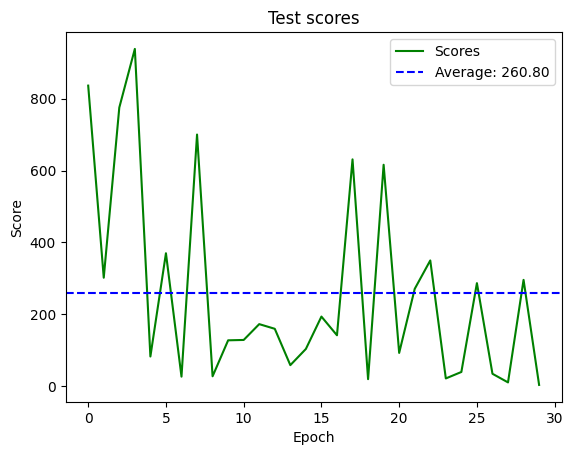

In [8]:
# Testing
env, _, _ = get_env(
    difficulty="hard",
    from_file="model_2_5k",
    testing=True,
    agent_cached=True,
    testing_render_mode="human",
)

test(
    env=env,
    agent=agent,
    test_epochs=30,
)

env.close()